In [24]:
import json
import pandas as pd
import glob
import os

# --- [설정] 분석 기준값 ---
TARGET_TIME_SEC = 600       # 분석 시점: 게임 시작 후 10분 (600초)
VEHICLE_USAGE_WINDOW = 180  # 차량 인정 범위: 10분 기준 과거 3분(180초) 이내 탑승 기록
TOP_N_THRESHOLD = 4         # 목표 순위: Top 4
AI_TEAM_ID_START = 200      # AI 팀 ID 시작 번호 (이 번호 이상은 봇으로 간주)

# --- [함수] 아이템 레벨 파싱 ---
def get_item_level(item_id):
    """아이템 ID에서 레벨(1, 2, 3)을 추출합니다."""
    # 헬멧(Head) 및 조끼(Armor/Vest)
    if 'Head' in item_id:
        if '01' in item_id: return 1
        if '02' in item_id: return 2
        if '03' in item_id: return 3
    if 'Armor' in item_id or 'Vest' in item_id:
        if '01' in item_id: return 1
        if '02' in item_id: return 2
        if '03' in item_id: return 3
    return 0

# --- [핵심 로직] 개별 로그 파일 처리 ---
def process_match_log(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            logs = [json.loads(line) for line in f]
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return []

    # 데이터 임시 저장소
    team_players = {}           
    team_final_ranks = {}       
    player_status_at_time = {}  
    team_last_vehicle_time = {} 
    
    team_kill_counts = {}       
    player_equipment = {}       

    for log in logs:
        log_type = log.get('_T')
        elapsed_time = log.get('elapsedTime', 0)
        
        # 1. 시간 흐름에 따른 이벤트 (10분 시점 이전 데이터만 반영)
        if elapsed_time <= TARGET_TIME_SEC:
            
            # (1) 킬 카운트 (수정됨: killer/victim이 None일 경우 방어 로직 추가)
            if log_type == 'LogPlayerKillV2':
                victim = log.get('victim')
                killer = log.get('killer')
                
                # victim이나 killer가 None(자기장사, 낙사 등)일 경우 안전하게 처리
                victim_team = victim.get('teamId', -1) if victim else -1
                killer_team = killer.get('teamId', -1) if killer else -1
                
                # 피해자가 봇이 아니고(-1 제외), 킬러가 명확한 유저 팀일 경우에만
                if victim_team != -1 and victim_team < AI_TEAM_ID_START:
                    if killer_team != -1 and killer_team < AI_TEAM_ID_START:
                        team_kill_counts[killer_team] = team_kill_counts.get(killer_team, 0) + 1
            
            # (2) 아이템 착용 정보 (유저 팀만)
            elif log_type == 'LogItemEquip':
                char = log.get('character', {})
                team_id = char.get('teamId', -1)
                
                if team_id < AI_TEAM_ID_START:
                    name = char.get('name')
                    item = log.get('item', {})
                    item_id = item.get('itemId', '')
                    
                    if name:
                        if name not in player_equipment:
                            player_equipment[name] = {'head': 0, 'armor': 0}
                        
                        level = get_item_level(item_id)
                        if level > 0:
                            if 'Head' in item_id:
                                player_equipment[name]['head'] = level
                            elif 'Armor' in item_id or 'Vest' in item_id:
                                player_equipment[name]['armor'] = level

            # (3) 차량 탑승 기록 (유저 팀만)
            elif log_type == 'LogPlayerPosition':
                char = log.get('character', {})
                team_id = char.get('teamId', -1)
                
                if team_id < AI_TEAM_ID_START:
                    if char.get('isInVehicle'):
                        team_last_vehicle_time[team_id] = elapsed_time

        # 2. 전체 정보 수집 (순위 및 스냅샷 생성)
        if log_type == 'LogPlayerPosition':
            char = log.get('character', {})
            name = char.get('name')
            team_id = char.get('teamId', -1)
            ranking = char.get('ranking')

            # 유저 팀만 처리
            if team_id < AI_TEAM_ID_START:
                if team_id not in team_players:
                    team_players[team_id] = set()
                team_players[team_id].add(name)
                
                if ranking != 0:
                    team_final_ranks[team_id] = ranking
                
                # 10분 시점 스냅샷
                if elapsed_time <= TARGET_TIME_SEC:
                    player_status_at_time[name] = {
                        'teamId': team_id,
                        'health': char.get('health', 0),
                        'isInBlueZone': char.get('isInBlueZone', False),
                    }

    # 3. 데이터셋 조립
    dataset = []
    
    for team_id, players in team_players.items():
        if team_id >= AI_TEAM_ID_START: continue 

        final_rank = team_final_ranks.get(team_id, 100)
        is_top_n = 1 if final_rank <= TOP_N_THRESHOLD else 0
        
        alive_count = 0
        total_health = 0
        in_bluezone_count = 0
        total_armor_score = 0
        
        valid_data_points = 0
        
        for player in players:
            status = player_status_at_time.get(player)
            if status:
                valid_data_points += 1
                if status['health'] > 0:
                    alive_count += 1
                    total_health += status['health']
                    if not status['isInBlueZone']: 
                        in_bluezone_count += 1
                    
                    equip = player_equipment.get(player, {'head': 0, 'armor': 0})
                    total_armor_score += equip['head'] + equip['armor']
        
        last_ride = team_last_vehicle_time.get(team_id, -9999)
        time_since_ride = TARGET_TIME_SEC - last_ride
        has_vehicle = 1 if (0 <= time_since_ride <= VEHICLE_USAGE_WINDOW) else 0

        if valid_data_points > 0:
            dataset.append({
                'match_id': os.path.basename(file_path),
                'team_id': team_id,
                'num_alive': alive_count,
                'total_health': total_health,
                'human_kills': team_kill_counts.get(team_id, 0),
                'total_armor_score': total_armor_score,
                'has_vehicle': has_vehicle,
                'num_safe_zone': in_bluezone_count,
                'final_rank': final_rank,
                'target_is_top_n': is_top_n
            })

    return dataset

# --- [메인 실행] ---
# 사용자 폴더 경로 (여기에 jsonl 파일들을 넣어주세요)
log_folder_path = 'G:/내 드라이브/pubg_telemetry_summary'  # <-- 실제 경로로 변경 필요

all_data = []
# 지정된 폴더의 모든 .jsonl 파일 찾기
file_list = glob.glob(os.path.join(log_folder_path, "*squad_Baltic_Main.jsonl"))
file_list = file_list[:500] #일단 500개만 테스트

print(f"총 {len(file_list)}개의 파일을 찾았습니다. 분석을 시작합니다...")

for i, file_path in enumerate(file_list):
    # 진행 상황 출력
    if (i + 1) % 10 == 0:
        print(f"[{i+1}/{len(file_list)}] 처리 중...")
        
    match_data = process_match_log(file_path)
    all_data.extend(match_data)

# 결과 DataFrame 생성
if all_data:
    df_final = pd.DataFrame(all_data)
    print("\n분석 완료!")
    print(f"총 {len(df_final)}개의 팀 데이터가 추출되었습니다.")
    print(df_final.head())
    
    # CSV로 저장 (선택 사항)
    df_final.to_csv("pubg_analysis_data.csv", index=False)
else:
    print("추출된 데이터가 없습니다. 폴더 경로를 확인하거나 파일 내용을 확인해주세요.")

총 500개의 파일을 찾았습니다. 분석을 시작합니다...
[10/500] 처리 중...
[20/500] 처리 중...
[30/500] 처리 중...
[40/500] 처리 중...
[50/500] 처리 중...
[60/500] 처리 중...
[70/500] 처리 중...
[80/500] 처리 중...
[90/500] 처리 중...
[100/500] 처리 중...
[110/500] 처리 중...
[120/500] 처리 중...
[130/500] 처리 중...
[140/500] 처리 중...
[150/500] 처리 중...
[160/500] 처리 중...
[170/500] 처리 중...
[180/500] 처리 중...
[190/500] 처리 중...
[200/500] 처리 중...
[210/500] 처리 중...
[220/500] 처리 중...
[230/500] 처리 중...
[240/500] 처리 중...
[250/500] 처리 중...
[260/500] 처리 중...
[270/500] 처리 중...
[280/500] 처리 중...
[290/500] 처리 중...
[300/500] 처리 중...
[310/500] 처리 중...
[320/500] 처리 중...
[330/500] 처리 중...
[340/500] 처리 중...
[350/500] 처리 중...
[360/500] 처리 중...
[370/500] 처리 중...
[380/500] 처리 중...
[390/500] 처리 중...
[400/500] 처리 중...
[410/500] 처리 중...
[420/500] 처리 중...
[430/500] 처리 중...
[440/500] 처리 중...
[450/500] 처리 중...
[460/500] 처리 중...
[470/500] 처리 중...
[480/500] 처리 중...
[490/500] 처리 중...
[500/500] 처리 중...

분석 완료!
총 6220개의 팀 데이터가 추출되었습니다.
                                  match_id  

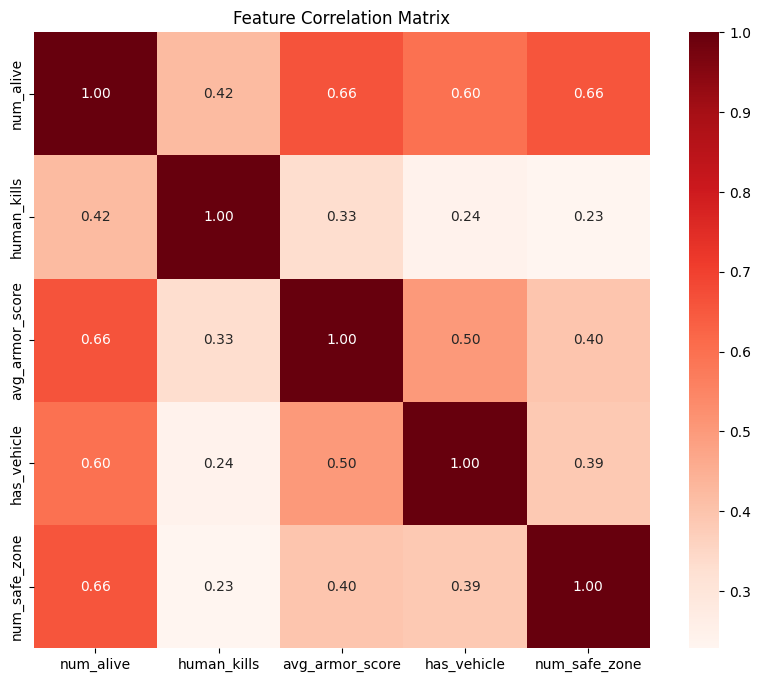

In [71]:
#독립변수들 간 다중공선성 확인
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 상관계수 행렬 계산
corr_matrix = df_final[['num_alive', 'human_kills', 'avg_armor_score', 'has_vehicle', 'num_safe_zone']].corr()

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='Reds', square=True)
plt.title("Feature Correlation Matrix")
plt.show()

In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF (Variance Inflation Factor) 계산을 통한 다중공선성 분석

# 피처 목록 정의
features = ['human_kills', 'avg_armor_score', 'has_vehicle', 'num_safe_zone']

# X 데이터 준비
X = df_final[features]

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Feature"] = features
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(features))]

print("=== VIF (Variance Inflation Factor) 분석 ===")
print("VIF > 10: 심각한 다중공선성")
print("VIF > 5: 다중공선성 주의")
print("VIF < 5: 양호\n")
display(vif_data.sort_values(by='VIF', ascending=False))

=== VIF (Variance Inflation Factor) 분석 ===
VIF > 10: 심각한 다중공선성
VIF > 5: 다중공선성 주의
VIF < 5: 양호



,Feature,VIF
1,avg_armor_score,3.503124
2,has_vehicle,2.479876
3,num_safe_zone,2.325151
0,human_kills,1.903070


In [39]:
#total_armor_score를 avg_armor_score로 변경
df_final['avg_armor_score'] = df_final.apply(lambda row: row['total_armor_score'] / row['num_alive'] if row['num_alive'] > 0 else 0, axis=1)
df_final.drop(columns=['total_armor_score'], inplace=True)

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np

# 1. 학습에 사용할 변수(X)와 정답(y) 분리
# 분석할 피처(Feature) 목록
features = ['human_kills', 'avg_armor_score', 'has_vehicle', 'num_safe_zone']

X = df_final[features]
y = df_final['target_is_top_n']

# 2. 학습용(Train)과 테스트용(Test) 데이터 분리 (8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 로지스틱 회귀 모델 학습
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 4. 성능 평가
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"=== 모델 정확도: {acc*100:.2f}% ===")
print("\n[상세 리포트]")
print(classification_report(y_test, y_pred))

# 5. [중요] 어떤 변수가 승리에 영향을 미쳤는지 확인 (회귀 계수)
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0], # 계수 값 (양수면 승률 UP, 음수면 DOWN)
    'Importance': np.abs(model.coef_[0]) # 영향력 크기 (절댓값)
}).sort_values(by='Coefficient', ascending=False)

print("\n[승리 요인 중요도 순서]")
display(coef_df) # 주피터 노트북에서는 print 대신 display가 표를 예쁘게 보여줍니다.

=== 모델 정확도: 81.27% ===

[상세 리포트]
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       985
           1       0.61      0.27      0.38       259

    accuracy                           0.81      1244
   macro avg       0.72      0.61      0.63      1244
weighted avg       0.79      0.81      0.78      1244


[승리 요인 중요도 순서]


,Feature,Coefficient,Importance
2,has_vehicle,0.903007,0.903007
1,avg_armor_score,0.793078,0.793078
0,human_kills,0.184001,0.184001
3,num_safe_zone,0.166982,0.166982


# 20분

In [72]:
import json
import pandas as pd
import glob
import os

# --- [설정] 분석 기준값 ---
TARGET_TIME_SEC = 1200       # 분석 시점: 게임 시작 후 10분 (600초)
VEHICLE_USAGE_WINDOW = 180  # 차량 인정 범위: 10분 기준 과거 3분(180초) 이내 탑승 기록
TOP_N_THRESHOLD = 4         # 목표 순위: Top 4
AI_TEAM_ID_START = 200      # AI 팀 ID 시작 번호 (이 번호 이상은 봇으로 간주)

# --- [메인 실행] ---
# 사용자 폴더 경로 (여기에 jsonl 파일들을 넣어주세요)
log_folder_path = 'G:/내 드라이브/pubg_telemetry_summary'  # <-- 실제 경로로 변경 필요

all_data = []
# 지정된 폴더의 모든 .jsonl 파일 찾기
file_list = glob.glob(os.path.join(log_folder_path, "*squad_Baltic_Main.jsonl"))
file_list = file_list[:500] #일단 500개만 테스트

print(f"총 {len(file_list)}개의 파일을 찾았습니다. 분석을 시작합니다...")

for i, file_path in enumerate(file_list):
    # 진행 상황 출력
    if (i + 1) % 10 == 0:
        print(f"[{i+1}/{len(file_list)}] 처리 중...")
        
    match_data = process_match_log(file_path)
    all_data.extend(match_data)

# 결과 DataFrame 생성
if all_data:
    df_final_20m = pd.DataFrame(all_data)
    print("\n분석 완료!")
    print(f"총 {len(df_final_20m)}개의 팀 데이터가 추출되었습니다.")
    print(df_final_20m.head())
    
    # CSV로 저장 (선택 사항)
    df_final_20m.to_csv("pubg_analysis_data.csv", index=False)
else:
    print("추출된 데이터가 없습니다. 폴더 경로를 확인하거나 파일 내용을 확인해주세요.")

총 500개의 파일을 찾았습니다. 분석을 시작합니다...
[10/500] 처리 중...
[10/500] 처리 중...


KeyboardInterrupt: 

In [60]:
#total_health와 total_armor_score를 avg로 변경
df_final_20m['avg_armor_score'] = df_final_20m.apply(lambda row: row['total_armor_score'] / row['num_alive'] if row['num_alive'] > 0 else 0, axis=1)
df_final_20m.drop(columns=['total_armor_score'], inplace=True)
df_final_20m['avg_health'] = df_final_20m.apply(lambda row: row['total_health'] / row['num_alive'] if row['num_alive'] > 0 else 0, axis=1)
df_final_20m.drop(columns=['total_health'], inplace=True)

# num_safe_zone을 ratio_safe_zone으로 변경
df_final_20m['ratio_safe_zone'] = df_final_20m.apply(lambda row: row['num_safe_zone'] / row['num_alive'] if row['num_alive'] > 0 else 0, axis=1)
df_final_20m.drop(columns=['num_safe_zone'], inplace=True)

=== VIF (Variance Inflation Factor) 분석 ===
VIF > 10: 심각한 다중공선성
VIF > 5: 다중공선성 주의
VIF < 5: 양호



,Feature,VIF
1,num_alive,2.412957
0,human_kills,1.973361
2,has_vehicle,1.920724


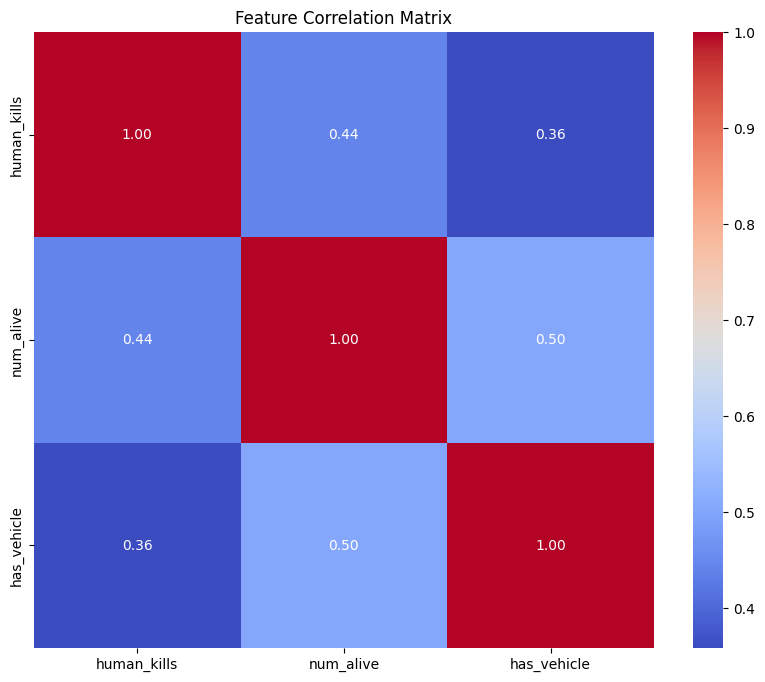

In [73]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF (Variance Inflation Factor) 계산을 통한 다중공선성 분석

# 피처 목록 정의
features = ['human_kills', 'num_alive','has_vehicle']

# X 데이터 준비
X = df_final_20m[features]

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Feature"] = features
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(features))]

print("=== VIF (Variance Inflation Factor) 분석 ===")
print("VIF > 10: 심각한 다중공선성")
print("VIF > 5: 다중공선성 주의")
print("VIF < 5: 양호\n")
display(vif_data.sort_values(by='VIF', ascending=False))

# 상관계수 행렬
corr_matrix = X.corr()
# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np

# 1. 학습에 사용할 변수(X)와 정답(y) 분리
# 분석할 피처(Feature) 목록
features = ['human_kills', 'num_alive','has_vehicle']

X = df_final_20m[features]
y = df_final_20m['target_is_top_n']

# 2. 학습용(Train)과 테스트용(Test) 데이터 분리 (8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 로지스틱 회귀 모델 학습
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 4. 성능 평가
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"=== 모델 정확도: {acc*100:.2f}% ===")
print("\n[상세 리포트]")
print(classification_report(y_test, y_pred))

# 5. [중요] 어떤 변수가 승리에 영향을 미쳤는지 확인 (회귀 계수)
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0], # 계수 값 (양수면 승률 UP, 음수면 DOWN)
    'Importance': np.abs(model.coef_[0]) # 영향력 크기 (절댓값)
}).sort_values(by='Coefficient', ascending=False)

print("\n[승리 요인 중요도 순서]")
display(coef_df) # 주피터 노트북에서는 print 대신 display가 표를 예쁘게 보여줍니다.

=== 모델 정확도: 84.49% ===

[상세 리포트]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       985
           1       0.67      0.50      0.57       259

    accuracy                           0.84      1244
   macro avg       0.77      0.72      0.74      1244
weighted avg       0.83      0.84      0.84      1244


[승리 요인 중요도 순서]


,Feature,Coefficient,Importance
2,has_vehicle,1.305546,1.305546
1,num_alive,0.886578,0.886578
0,human_kills,0.088956,0.088956
